In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-06 01:06:44.709299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 01:06:44.717070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 01:06:44.717553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-06 01:06:45.029210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 01:06:45.029929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 01:06:45.030456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 01:06:45.030920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[0.00000000e+00, 2.90065479e+00, 2.44002056e+00],
         [0.00000000e+00, 8.77167463e-01, 1.87986517e+00],
         [2.32892132e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 5.18729639e+00],
         [0.00000000e+00, 1.71399045e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.48086905e+00]],

        [[0.00000000e+00, 2.36738968e+00, 8.04011464e-01],
         [0.00000000e+00, 0.00000000e+00, 2.01901960e+00],
         [2.58779287e+00, 5.03431201e-01, 2.55340958e+00],
         ...,
         [3.05731988e+00, 1.99671134e-01, 0.00000000e+00],
         [2.37327576e+00, 0.00000000e+00, 2.53645718e-01],
         [0.00000000e+00, 2.63490766e-01, 4.10419732e-01]],

        [[5.37263691e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.00000000e+00, 2.90065479e+00, 2.44002056e+00],
          [0.00000000e+00, 8.77167463e-01, 1.87986517e+00],
          [2.32892132e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 5.18729639e+00],
          [0.00000000e+00, 1.71399045e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 1.48086905e+00]],
 
         [[0.00000000e+00, 2.36738968e+00, 8.04011464e-01],
          [0.00000000e+00, 0.00000000e+00, 2.01901960e+00],
          [2.58779287e+00, 5.03431201e-01, 2.55340958e+00],
          ...,
          [3.05731988e+00, 1.99671134e-01, 0.00000000e+00],
          [2.37327576e+00, 0.00000000e+00, 2.53645718e-01],
          [0.00000000e+00, 2.63490766e-01, 4.10419732e-01]],
 
         [[5.37263691e-01, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+0

<IPython.core.display.Javascript object>


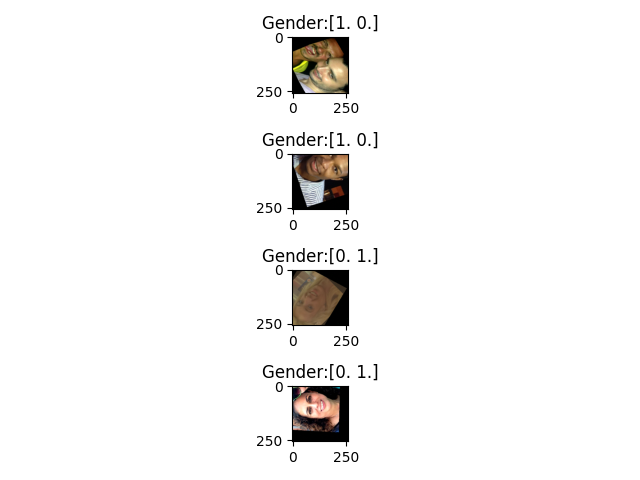

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 7, strides=(4,4), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 5, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(32, 1, padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(1024, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_18')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 128

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 128)          1566496     ['tf.math.subtract[0][0]']   

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_18"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-06 01:06:52.168640: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-06 01:06:52.168659: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-06 01:06:52.168680: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-06 01:06:52.274462: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-06 01:06:52.275732: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-06 01:06:52.906382: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  14/3528 [..............................] - ETA: 14s - loss: 7269.3159 - gender_out_loss: 0.6952 - tf.math.multiply_1_loss: 5531.3149 - gender_out_accuracy: 0.4286    

2022-11-06 01:06:53.638344: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 15s 4ms/step - loss: 7717.8882 - gender_out_loss: 0.6909 - tf.math.multiply_1_loss: 5990.6602 - gender_out_accuracy: 0.5192
Epoch 1/300
   1/1000 [..............................] - ETA: 15:05 - loss: 9089.2070 - gender_out_loss: 0.6840 - tf.math.multiply_1_loss: 7379.0859 - gender_out_accuracy: 0.7500

2022-11-06 01:07:07.889138: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-06 01:07:07.889227: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  10/1000 [..............................] - ETA: 1:13 - loss: 8903.6855 - gender_out_loss: 0.6741 - tf.math.multiply_1_loss: 7218.3428 - gender_out_accuracy: 0.5750

2022-11-06 01:07:08.362925: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-06 01:07:08.363915: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-06 01:07:08.397097: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 2927 callback api events and 2886 activity events. 
2022-11-06 01:07:08.422430: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-06 01:07:08.454896: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_18/log_0/plugins/profile/2022_11_06_01_07_08

2022-11-06 01:07:08.498943: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_18/log_0/plugins/profile/2022_11_06_01_07_08/rachanon-pc1.trace.json.gz
2022-11-06 01:07:08.538203: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

1000/1000 [==============================] - 22s 21ms/step - loss: 4467.0952 - gender_out_loss: 0.6695 - tf.math.multiply_1_loss: 2793.4241 - gender_out_accuracy: 0.5972 - val_loss: 3726.6924 - val_gender_out_loss: 0.6775 - val_tf.math.multiply_1_loss: 2033.0372 - val_gender_out_accuracy: 0.5740
Epoch 2/300
1000/1000 [==============================] - 20s 20ms/step - loss: 3181.5857 - gender_out_loss: 0.6502 - tf.math.multiply_1_loss: 1556.1084 - gender_out_accuracy: 0.6310 - val_loss: 3260.7515 - val_gender_out_loss: 0.6818 - val_tf.math.multiply_1_loss: 1556.3563 - val_gender_out_accuracy: 0.5615
Epoch 3/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2887.0432 - gender_out_loss: 0.6420 - tf.math.multiply_1_loss: 1282.0319 - gender_out_accuracy: 0.6112 - val_loss: 3097.2549 - val_gender_out_loss: 0.6858 - val_tf.math.multiply_1_loss: 1382.7153 - val_gender_out_accuracy: 0.5521
Epoch 4/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2812.5

Epoch 28/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2340.0994 - gender_out_loss: 0.6433 - tf.math.multiply_1_loss: 731.8117 - gender_out_accuracy: 0.6217 - val_loss: 2583.6558 - val_gender_out_loss: 0.6834 - val_tf.math.multiply_1_loss: 875.2454 - val_gender_out_accuracy: 0.5769
Epoch 29/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2295.0999 - gender_out_loss: 0.6373 - tf.math.multiply_1_loss: 701.8183 - gender_out_accuracy: 0.6407 - val_loss: 2520.3157 - val_gender_out_loss: 0.6698 - val_tf.math.multiply_1_loss: 845.6979 - val_gender_out_accuracy: 0.5939
Epoch 30/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2250.9578 - gender_out_loss: 0.6167 - tf.math.multiply_1_loss: 709.1313 - gender_out_accuracy: 0.6525 - val_loss: 2574.9958 - val_gender_out_loss: 0.7010 - val_tf.math.multiply_1_loss: 822.4733 - val_gender_out_accuracy: 0.5593
Epoch 31/300
1000/1000 [==============================] - 20s 20ms/step - lo

Epoch 55/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2158.2244 - gender_out_loss: 0.6108 - tf.math.multiply_1_loss: 631.1093 - gender_out_accuracy: 0.6670 - val_loss: 2373.0654 - val_gender_out_loss: 0.6499 - val_tf.math.multiply_1_loss: 748.4278 - val_gender_out_accuracy: 0.6245
Epoch 56/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2106.4363 - gender_out_loss: 0.5952 - tf.math.multiply_1_loss: 618.4479 - gender_out_accuracy: 0.6708 - val_loss: 2341.8853 - val_gender_out_loss: 0.6355 - val_tf.math.multiply_1_loss: 753.0322 - val_gender_out_accuracy: 0.6306
Epoch 57/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2142.6113 - gender_out_loss: 0.6082 - tf.math.multiply_1_loss: 622.1238 - gender_out_accuracy: 0.6725 - val_loss: 2428.9993 - val_gender_out_loss: 0.6692 - val_tf.math.multiply_1_loss: 756.0422 - val_gender_out_accuracy: 0.6036
Epoch 58/300
1000/1000 [==============================] - 20s 20ms/step - lo

Epoch 82/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2110.6536 - gender_out_loss: 0.6036 - tf.math.multiply_1_loss: 601.5717 - gender_out_accuracy: 0.6833 - val_loss: 2211.6448 - val_gender_out_loss: 0.5968 - val_tf.math.multiply_1_loss: 719.5988 - val_gender_out_accuracy: 0.6907
Epoch 83/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1996.3402 - gender_out_loss: 0.5566 - tf.math.multiply_1_loss: 604.9354 - gender_out_accuracy: 0.7165 - val_loss: 2458.3472 - val_gender_out_loss: 0.6877 - val_tf.math.multiply_1_loss: 739.2086 - val_gender_out_accuracy: 0.5897
Epoch 84/300
1000/1000 [==============================] - 20s 20ms/step - loss: 2021.2181 - gender_out_loss: 0.5754 - tf.math.multiply_1_loss: 582.7601 - gender_out_accuracy: 0.7060 - val_loss: 2292.5486 - val_gender_out_loss: 0.6297 - val_tf.math.multiply_1_loss: 718.3075 - val_gender_out_accuracy: 0.6395
Epoch 85/300
1000/1000 [==============================] - 20s 20ms/step - lo

Epoch 109/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1968.5502 - gender_out_loss: 0.5484 - tf.math.multiply_1_loss: 597.5562 - gender_out_accuracy: 0.7078 - val_loss: 2146.4771 - val_gender_out_loss: 0.5732 - val_tf.math.multiply_1_loss: 713.4106 - val_gender_out_accuracy: 0.7158
Epoch 110/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1995.2563 - gender_out_loss: 0.5644 - tf.math.multiply_1_loss: 584.1697 - gender_out_accuracy: 0.7097 - val_loss: 2390.7605 - val_gender_out_loss: 0.6733 - val_tf.math.multiply_1_loss: 707.4574 - val_gender_out_accuracy: 0.6216
Epoch 111/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1921.3156 - gender_out_loss: 0.5391 - tf.math.multiply_1_loss: 573.6711 - gender_out_accuracy: 0.7278 - val_loss: 2334.9851 - val_gender_out_loss: 0.6553 - val_tf.math.multiply_1_loss: 696.7884 - val_gender_out_accuracy: 0.6484
Epoch 112/300
1000/1000 [==============================] - 20s 20ms/step 

1000/1000 [==============================] - 20s 20ms/step - loss: 1874.5537 - gender_out_loss: 0.5224 - tf.math.multiply_1_loss: 568.5323 - gender_out_accuracy: 0.7475 - val_loss: 2029.1337 - val_gender_out_loss: 0.5320 - val_tf.math.multiply_1_loss: 699.2096 - val_gender_out_accuracy: 0.7348
Epoch 136/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1871.1360 - gender_out_loss: 0.5141 - tf.math.multiply_1_loss: 585.8762 - gender_out_accuracy: 0.7415 - val_loss: 2108.8647 - val_gender_out_loss: 0.5629 - val_tf.math.multiply_1_loss: 701.6443 - val_gender_out_accuracy: 0.7085
Epoch 137/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1936.1415 - gender_out_loss: 0.5456 - tf.math.multiply_1_loss: 572.1504 - gender_out_accuracy: 0.7190 - val_loss: 2088.8542 - val_gender_out_loss: 0.5488 - val_tf.math.multiply_1_loss: 716.7659 - val_gender_out_accuracy: 0.7170
Epoch 138/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1943.0

1000/1000 [==============================] - 20s 20ms/step - loss: 1859.8386 - gender_out_loss: 0.5280 - tf.math.multiply_1_loss: 539.7818 - gender_out_accuracy: 0.7275 - val_loss: 2323.8293 - val_gender_out_loss: 0.6546 - val_tf.math.multiply_1_loss: 687.3123 - val_gender_out_accuracy: 0.6504
Epoch 162/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1912.8353 - gender_out_loss: 0.5345 - tf.math.multiply_1_loss: 576.5659 - gender_out_accuracy: 0.7270 - val_loss: 2245.1301 - val_gender_out_loss: 0.6185 - val_tf.math.multiply_1_loss: 698.8491 - val_gender_out_accuracy: 0.6712
Epoch 163/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1855.2404 - gender_out_loss: 0.5142 - tf.math.multiply_1_loss: 569.6671 - gender_out_accuracy: 0.7473 - val_loss: 2004.7206 - val_gender_out_loss: 0.5251 - val_tf.math.multiply_1_loss: 691.8616 - val_gender_out_accuracy: 0.7389
Epoch 164/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1797.6

1000/1000 [==============================] - 20s 20ms/step - loss: 1898.8143 - gender_out_loss: 0.5312 - tf.math.multiply_1_loss: 570.7869 - gender_out_accuracy: 0.7393 - val_loss: 2002.6837 - val_gender_out_loss: 0.5219 - val_tf.math.multiply_1_loss: 697.9055 - val_gender_out_accuracy: 0.7408
Epoch 188/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1722.8948 - gender_out_loss: 0.4665 - tf.math.multiply_1_loss: 556.5581 - gender_out_accuracy: 0.7730 - val_loss: 2032.8932 - val_gender_out_loss: 0.5321 - val_tf.math.multiply_1_loss: 702.6224 - val_gender_out_accuracy: 0.7518
Epoch 189/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1749.2958 - gender_out_loss: 0.4732 - tf.math.multiply_1_loss: 566.3517 - gender_out_accuracy: 0.7755 - val_loss: 2015.1799 - val_gender_out_loss: 0.5234 - val_tf.math.multiply_1_loss: 706.6065 - val_gender_out_accuracy: 0.7418
Epoch 190/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1799.9

1000/1000 [==============================] - 20s 20ms/step - loss: 1656.5398 - gender_out_loss: 0.4454 - tf.math.multiply_1_loss: 542.9922 - gender_out_accuracy: 0.7990 - val_loss: 1883.2491 - val_gender_out_loss: 0.4751 - val_tf.math.multiply_1_loss: 695.4222 - val_gender_out_accuracy: 0.7699
Epoch 214/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1709.5674 - gender_out_loss: 0.4645 - tf.math.multiply_1_loss: 548.2996 - gender_out_accuracy: 0.7707 - val_loss: 2022.5638 - val_gender_out_loss: 0.5309 - val_tf.math.multiply_1_loss: 695.2747 - val_gender_out_accuracy: 0.7391
Epoch 215/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1824.4167 - gender_out_loss: 0.4974 - tf.math.multiply_1_loss: 580.9751 - gender_out_accuracy: 0.7592 - val_loss: 1938.9813 - val_gender_out_loss: 0.4998 - val_tf.math.multiply_1_loss: 689.5051 - val_gender_out_accuracy: 0.7570
Epoch 216/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1698.8

1000/1000 [==============================] - 20s 20ms/step - loss: 1680.6189 - gender_out_loss: 0.4514 - tf.math.multiply_1_loss: 552.0678 - gender_out_accuracy: 0.7832 - val_loss: 1858.7839 - val_gender_out_loss: 0.4696 - val_tf.math.multiply_1_loss: 684.8960 - val_gender_out_accuracy: 0.7717
Epoch 240/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1742.1327 - gender_out_loss: 0.4705 - tf.math.multiply_1_loss: 565.7738 - gender_out_accuracy: 0.7680 - val_loss: 2037.8365 - val_gender_out_loss: 0.5325 - val_tf.math.multiply_1_loss: 706.6140 - val_gender_out_accuracy: 0.7637
Epoch 241/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1639.6887 - gender_out_loss: 0.4337 - tf.math.multiply_1_loss: 555.4947 - gender_out_accuracy: 0.7975 - val_loss: 2183.8303 - val_gender_out_loss: 0.5978 - val_tf.math.multiply_1_loss: 689.4493 - val_gender_out_accuracy: 0.7228
Epoch 242/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1728.3

1000/1000 [==============================] - 20s 20ms/step - loss: 1683.0039 - gender_out_loss: 0.4459 - tf.math.multiply_1_loss: 568.3700 - gender_out_accuracy: 0.7905 - val_loss: 1917.7490 - val_gender_out_loss: 0.4909 - val_tf.math.multiply_1_loss: 690.5102 - val_gender_out_accuracy: 0.7539
Epoch 266/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1575.2861 - gender_out_loss: 0.4166 - tf.math.multiply_1_loss: 533.8267 - gender_out_accuracy: 0.8043 - val_loss: 1923.8828 - val_gender_out_loss: 0.4939 - val_tf.math.multiply_1_loss: 689.1800 - val_gender_out_accuracy: 0.7632
Epoch 267/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1658.1940 - gender_out_loss: 0.4447 - tf.math.multiply_1_loss: 546.4850 - gender_out_accuracy: 0.7933 - val_loss: 1848.1388 - val_gender_out_loss: 0.4648 - val_tf.math.multiply_1_loss: 686.2528 - val_gender_out_accuracy: 0.7753
Epoch 268/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1735.3

1000/1000 [==============================] - 20s 20ms/step - loss: 1606.2498 - gender_out_loss: 0.4145 - tf.math.multiply_1_loss: 570.0236 - gender_out_accuracy: 0.8048 - val_loss: 2041.1517 - val_gender_out_loss: 0.5439 - val_tf.math.multiply_1_loss: 681.3229 - val_gender_out_accuracy: 0.7641
Epoch 292/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1654.8654 - gender_out_loss: 0.4488 - tf.math.multiply_1_loss: 532.8478 - gender_out_accuracy: 0.7865 - val_loss: 1829.7081 - val_gender_out_loss: 0.4585 - val_tf.math.multiply_1_loss: 683.3915 - val_gender_out_accuracy: 0.7805
Epoch 293/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1632.4373 - gender_out_loss: 0.4315 - tf.math.multiply_1_loss: 553.7374 - gender_out_accuracy: 0.7943 - val_loss: 2062.6084 - val_gender_out_loss: 0.5481 - val_tf.math.multiply_1_loss: 692.4562 - val_gender_out_accuracy: 0.7646
Epoch 294/300
1000/1000 [==============================] - 20s 20ms/step - loss: 1582.3

In [40]:
out = model(x)

In [41]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[4.11989117e+00, 3.59611177e+00, 2.69333339e+00],
          [1.98602426e+00, 1.80691707e+00, 1.40970922e+00],
          [1.26774883e+00, 9.11472321e-01, 7.70560622e-01],
          ...,
          [2.96627283e-01, 2.77689099e-01, 3.57135236e-01],
          [2.72300988e-01, 2.79452205e-01, 2.96148509e-01],
          [3.47666144e-01, 3.21044773e-01, 4.17400002e-01]],
 
         [[1.66174960e+00, 1.51436317e+00, 1.13452029e+00],
          [1.14363980e+00, 9.60292101e-01, 6.56787157e-01],
          [9.58863378e-01, 8.38782191e-01, 7.74839222e-01],
          ...,
          [2.01579183e-01, 2.00211257e-01, 2.21292526e-01],
          [1.56559199e-01, 1.88979059e-01, 2.16785967e-01],
          [2.49274224e-01, 2.39561945e-01, 3.64446044e-01]],
 
         [[1.21192980e+00, 1.09395373e+00, 8.48813653e-01],
          [7.92432308e-01, 8.81681919e-01, 4.66926545e-01],
          [6.04357600e-01, 5.78777313e-01, 3.91743779e-0

<IPython.core.display.Javascript object>


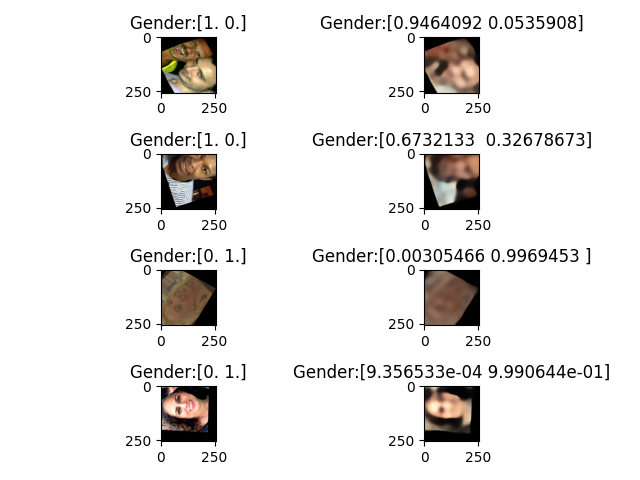

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [43]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [44]:
outTest = model(xTest)

In [45]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[6.21411085e-01, 5.13109267e-01, 4.24862802e-01],
          [2.80972123e-01, 1.99033320e-01, 1.45000219e-01],
          [1.79525167e-01, 1.48192048e-01, 1.61369741e-01],
          ...,
          [1.39566511e-01, 1.18485242e-01, 1.58580691e-01],
          [1.34163201e-01, 1.17535293e-01, 1.33973211e-01],
          [1.63725615e-01, 1.34702772e-01, 1.93318427e-01]],
 
         [[2.02764720e-01, 1.71446800e-01, 1.39809698e-01],
          [1.63611621e-01, 1.14662647e-01, 6.88675046e-02],
          [2.56843418e-01, 2.58796513e-01, 1.52425021e-01],
          ...,
          [9.56028700e-02, 8.57765973e-02, 1.05824322e-01],
          [7.78654218e-02, 8.66429508e-02, 1.00177824e-01],
          [1.54096931e-01, 1.25446469e-01, 2.05166191e-01]],
 
         [[4.12840247e-01, 4.97735292e-01, 3.46328616e-01],
          [3.85633707e-01, 4.18425947e-01, 1.90673769e-01],
          [3.41730863e-01, 2.95928121e-01, 2.05432177e-0

<IPython.core.display.Javascript object>


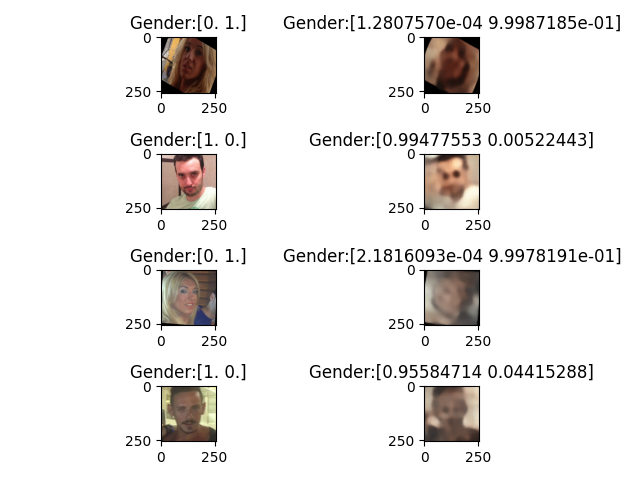

In [46]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()